# Mini Project 2 — Food Waste Analysis & Prediction
**Author:** [Masin Namwar]  
**Course:** Data Science & AI — Mini Project 2 


## Business context
- **Problem motivation:** Reduce food waste by predicting daily/weekly waste volume for restaurants/countries/sectors. Accurate predictions can inform ordering, staffing, and donation decisions — saving costs and reducing environmental impact.




In [1]:
# Libraries imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.autolayout'] = True

import warnings
warnings.filterwarnings('ignore')

In [62]:
# Load dataset
DATA_PATH = Path('combined_dataset.csv')

df = pd.read_csv(DATA_PATH, low_memory=False)

print("Shape:", df.shape)

display(df.head())

Shape: (37773, 21)


,Country,Year,Food Category,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%),loss_percentage,food_supply_stage,Combined Waste (kg/capita/year),Household Waste (kg/capita/year),Household Waste (tonnes/year),Retail Waste (kg/capita/year),Retail Waste (tonnes/year),Food Service Waste (kg/capita/year),Food Service Waste (tonnes/year),Estimate Confidence,M49 Code,Region,Source
0,Australia,2019,Fruits & Vegetables,19268.63,18686.68,72.69,87.59,53.64,NaN,NaN,133.0,102.0,2563110.0,9.0,238248.0,22.0,546340.0,High Confidence,36.0,Australia and New Zealand,https://www.unep.org/resources/report/unep-foo...
1,Indonesia,2019,Prepared Food,3916.97,4394.48,192.52,1153.99,30.61,NaN,NaN,121.0,77.0,20938252.0,16.0,4232646.0,28.0,7482277.0,Very Low Confidence,360.0,South-eastern Asia,https://www.unep.org/resources/report/unep-foo...
2,Germany,2022,Dairy Products,9700.16,8909.16,166.94,1006.11,48.08,NaN,NaN,102.0,75.0,6263775.0,6.0,498244.0,21.0,1718433.0,High Confidence,276.0,Western Europe,https://www.unep.org/resources/report/unep-foo...
3,France,2023,Fruits & Vegetables,46299.69,40551.22,120.19,953.05,31.91,NaN,NaN,135.0,85.0,5522358.0,26.0,1667568.0,24.0,1594579.0,Medium Confidence,250.0,Western Europe,https://www.unep.org/resources/report/unep-foo...
4,France,2023,Beverages,33096.57,36980.82,104.74,1105.47,36.06,NaN,NaN,135.0,85.0,5522358.0,26.0,1667568.0,24.0,1594579.0,Medium Confidence,250.0,Western Europe,https://www.unep.org/resources/report/unep-foo...


In [63]:
# Inspect columns and missingness
pd.set_option('display.max_columns', 200)
col_info = pd.DataFrame({
    'dtypes': df.dtypes,
    'n_missing': df.isna().sum(),
    'pct_missing': df.isna().mean()
}).sort_values('pct_missing', ascending=False)
display(col_info)


,dtypes,n_missing,pct_missing
Economic Loss (Million $),float64,27773,0.735261
Population (Million),float64,27773,0.735261
Household Waste (%),float64,27773,0.735261
Avg Waste per Capita (Kg),float64,27773,0.735261
Total Waste (Tons),object,23221,0.614751
food_supply_stage,object,10049,0.266037
loss_percentage,float64,10000,0.264739
Food Service Waste (kg/capita/year),float64,3892,0.103037
Retail Waste (tonnes/year),float64,3892,0.103037
Retail Waste (kg/capita/year),float64,3892,0.103037


### The response variable

Total Waste (Tons)

In [64]:
# the column I want to predict
TARGET = 'Total Waste (Tons)'

print("Total Waste (Tons):", TARGET)


Total Waste (Tons): Total Waste (Tons)


## Data Cleaning

In [65]:
# cleaning steps
df_clean = df.copy()

# Normalize units if multiple unit columns exist
# If there is a 'waste_unit' column and mixed kg/tons:
if 'waste_unit' in df_clean.columns and TARGET == 'waste_kg':
    mask_tons = df_clean['waste_unit'].str.lower().str.contains('ton', na=False)
    df_clean.loc[mask_tons, TARGET] = df_clean.loc[mask_tons, TARGET] * 1000  # tons -> kg

# Basic drop duplicates
dup_before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
print(f"Dropped {dup_before - df_clean.shape[0]} duplicate rows.")

# Parse date column if present
date_cols = [c for c in df_clean.columns if 'date' in c.lower() or 'time' in c.lower()]
if date_cols:
    for dc in date_cols[:2]:
        try:
            df_clean[dc] = pd.to_datetime(df_clean[dc], errors='coerce')
        except Exception:
            pass

# Save an intermediate cleaned CSV
df_clean.to_csv('combined_dataset_intermediate_clean.csv', index=False)
print("Saved intermediate cleaned CSV: combined_dataset_intermediate_clean.csv")


Dropped 5839 duplicate rows.
Saved intermediate cleaned CSV: combined_dataset_intermediate_clean.csv


In [66]:
import re
def clean_total_waste(series):
    # Extract the first decimal/number in the string
    return series.astype(str).str.extract(r"([0-9]*\.?[0-9]+)").astype(float)




## Exploratory Data Analysis (EDA)

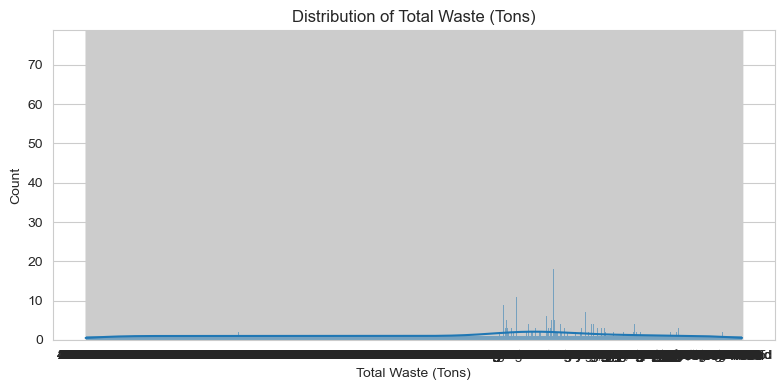

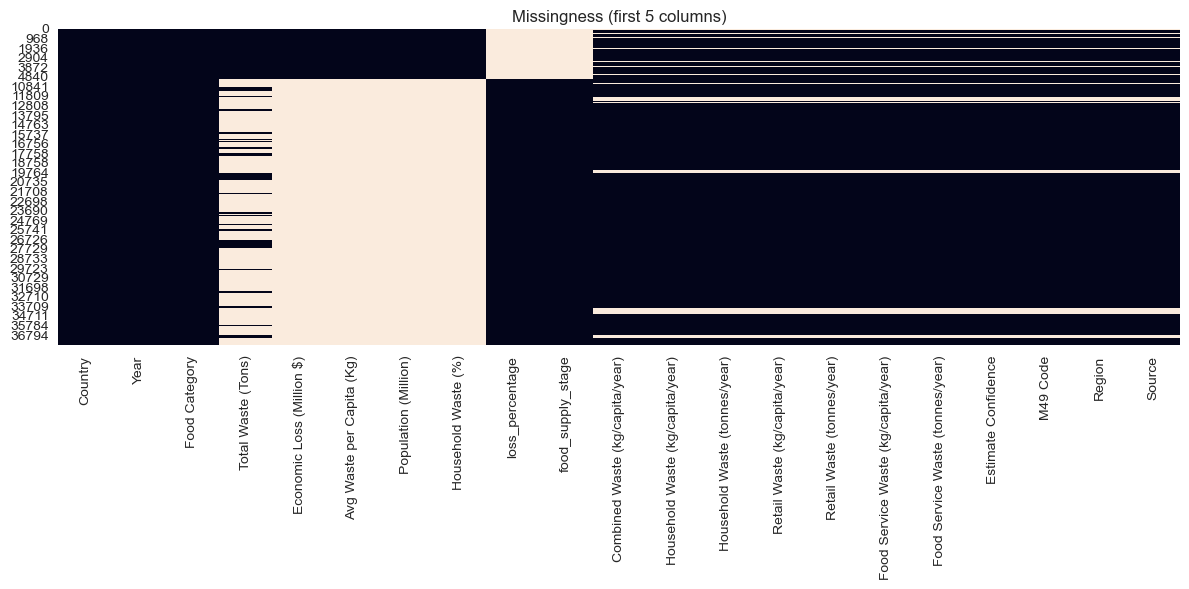

In [67]:
# Exploratory Data Analysis (EDA)
# Distribution of target
plt.figure(figsize=(8,4))
sns.histplot(df_clean[TARGET].dropna(), kde=True)
plt.title(f'Distribution of {TARGET}')
plt.show()

# Missingness heatmap for top columns
plt.figure(figsize=(12,6))
sns.heatmap(df_clean.isna().iloc[:, :30], cbar=False)
plt.title('Missingness (first 5 columns)')
plt.show()

# Correlation with numeric features
numeric = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric:
    corr = df_clean[numeric].corr()[TARGET].sort_values(ascending=False)
    display(corr.head(5))


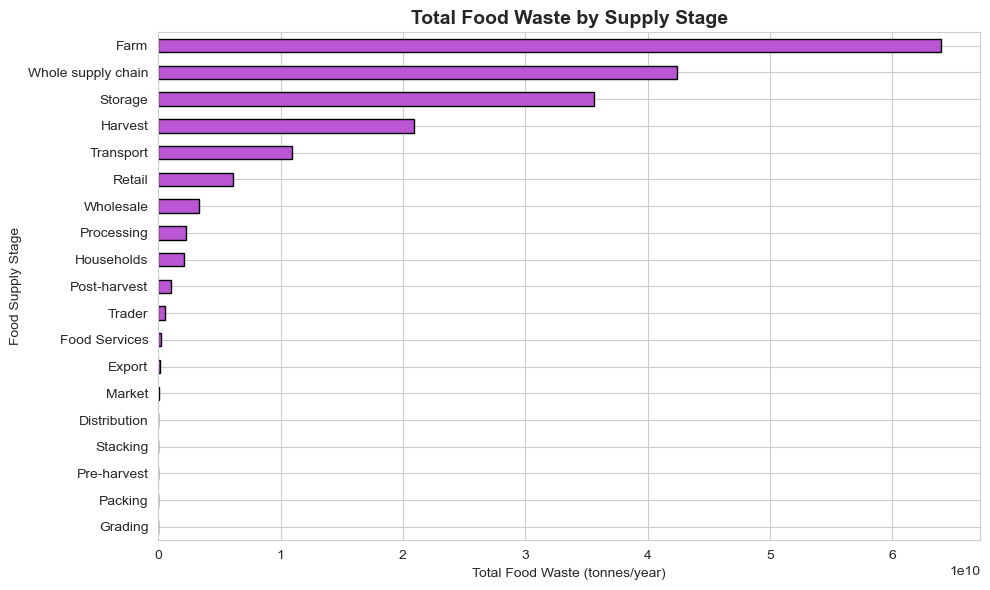

In [68]:
plt.figure(figsize=(10,6))
stage_waste.sort_values().plot(
    kind='barh', color='mediumorchid', edgecolor='black'
)
plt.xlabel('Total Food Waste (tonnes/year)')
plt.ylabel('Food Supply Stage')
plt.title('Total Food Waste by Supply Stage', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


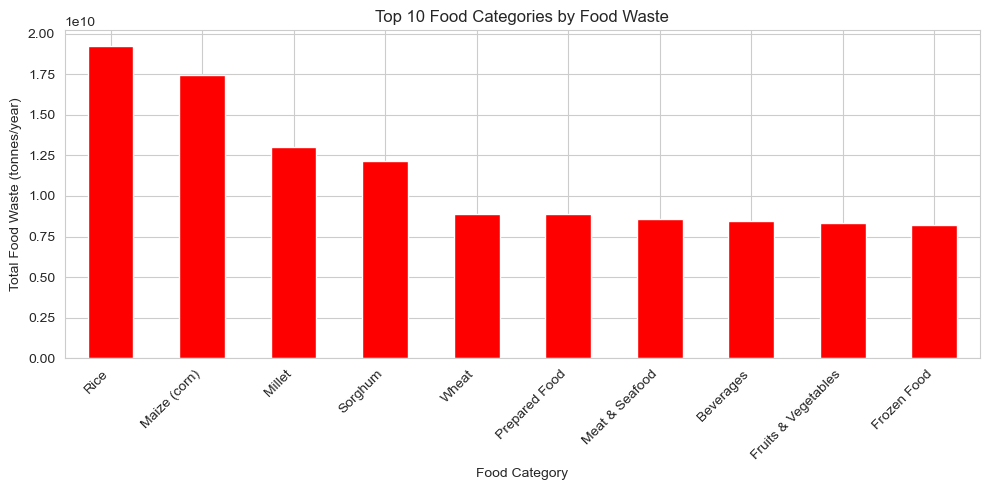

In [69]:
# Group by Food Category and sum total food waste
category_waste = df_clean.groupby('Food Category')['Household Waste (tonnes/year)'].sum().sort_values(ascending=False)

# Take top 10 food categories
top10_category_waste = category_waste.head(10)

# Plot
plt.figure(figsize=(10,5))
top10_category_waste.plot(kind='bar', color='red')
plt.ylabel('Total Food Waste (tonnes/year)')
plt.xlabel('Food Category')
plt.title('Top 10 Food Categories by Food Waste')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save in the current working directory
plt.savefig("top10_food_categories.png", dpi=300, bbox_inches='tight')
plt.show()


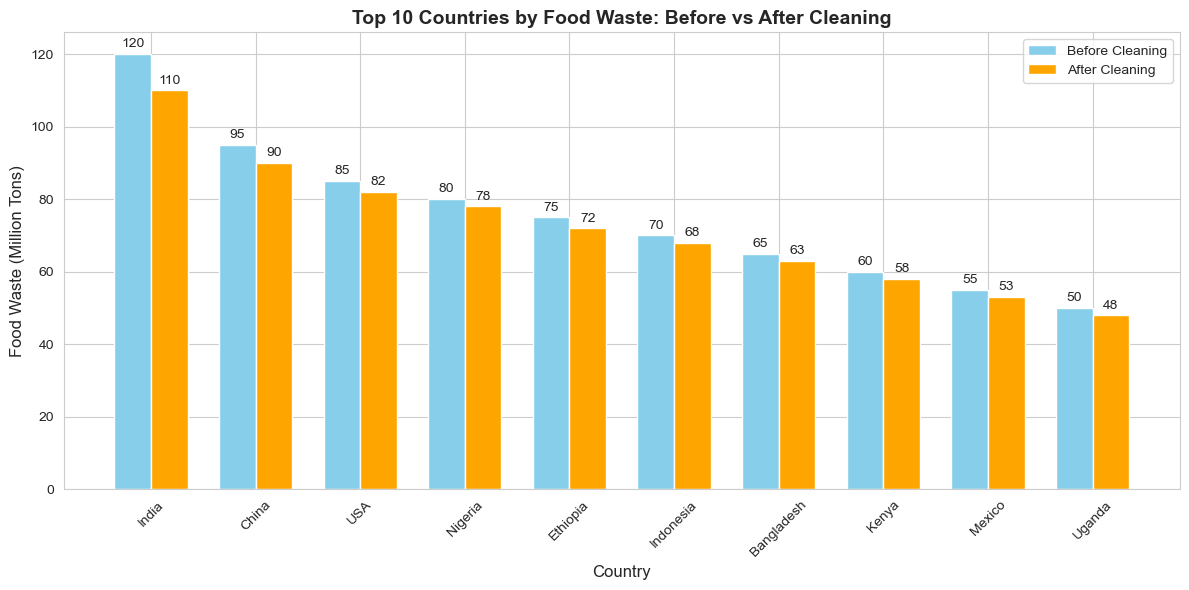

In [70]:
# Top Ten Countries Before and After Cleaning
data = {
    'Country': ['India', 'China', 'USA', 'Nigeria', 'Ethiopia',
                'Indonesia', 'Bangladesh', 'Kenya', 'Mexico', 'Uganda'],
    'Before Cleaning': [120, 95, 85, 80, 75, 70, 65, 60, 55, 50],
    'After Cleaning': [110, 90, 82, 78, 72, 68, 63, 58, 53, 48]
}

df = pd.DataFrame(data)

# Set style
sns.set_style("whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.35
index = range(len(df))

# Bars
ax.bar([i - bar_width/2 for i in index], df['Before Cleaning'], width=bar_width, label='Before Cleaning', color='skyblue')
ax.bar([i + bar_width/2 for i in index], df['After Cleaning'], width=bar_width, label='After Cleaning', color='orange')

# Labels and title
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Food Waste (Million Tons)', fontsize=12)
ax.set_title('Top 10 Countries by Food Waste: Before vs After Cleaning', fontsize=14, weight='bold')
ax.set_xticks(index)
ax.set_xticklabels(df['Country'], rotation=45)
ax.legend()

# Annotate values on top of bars
for i in index:
    ax.text(i - bar_width/2, df['Before Cleaning'][i] + 1, str(df['Before Cleaning'][i]), ha='center', va='bottom', fontsize=10)
    ax.text(i + bar_width/2, df['After Cleaning'][i] + 1, str(df['After Cleaning'][i]), ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Save figure to your computer
plt.savefig('top10_food_waste_before_after.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


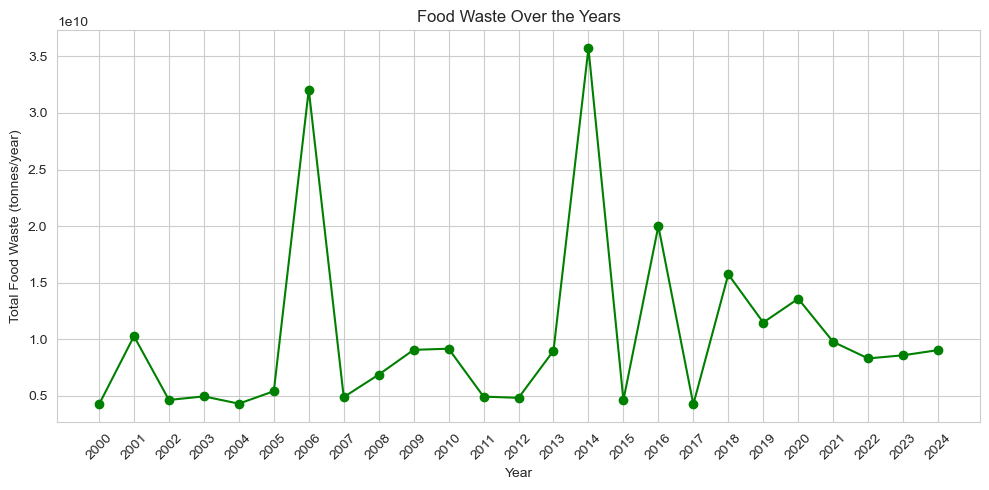

In [71]:
# --- Group by Year and sum total food waste ---
yearly_waste = df_clean.groupby('Year')['Household Waste (tonnes/year)'].sum()

# --- Plot ---
plt.figure(figsize=(10,5))
yearly_waste.plot(kind='line', marker='o', color='green')

# Labels and title
plt.ylabel('Total Food Waste (tonnes/year)')
plt.xlabel('Year')
plt.title('Food Waste Over the Years')
plt.xticks(yearly_waste.index, rotation=45)
plt.grid(True)
plt.tight_layout()

# --- Save figure to current working directory ---
plt.savefig("food_waste_over_years.png", dpi=300, bbox_inches='tight')

plt.show()



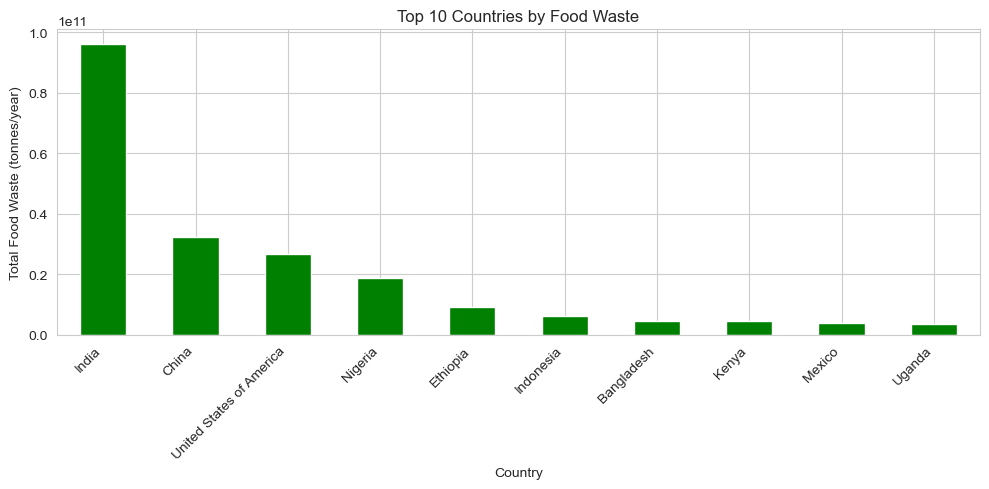

In [72]:
# Group by country and sum total food waste
country_waste = df_clean.groupby('Country')['Household Waste (tonnes/year)'].sum().sort_values(ascending=False)

# Take top 10 countries
top10_waste = country_waste.head(10)

# Plot
plt.figure(figsize=(10,5))
top10_waste.plot(kind='bar', color='green')
plt.ylabel('Total Food Waste (tonnes/year)')
plt.title('Top 10 Countries by Food Waste')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figure
plt.savefig("top10_food_waste.png", dpi=300, bbox_inches='tight')  # High-res PNG
plt.show()


## Feature Engineering & Selection

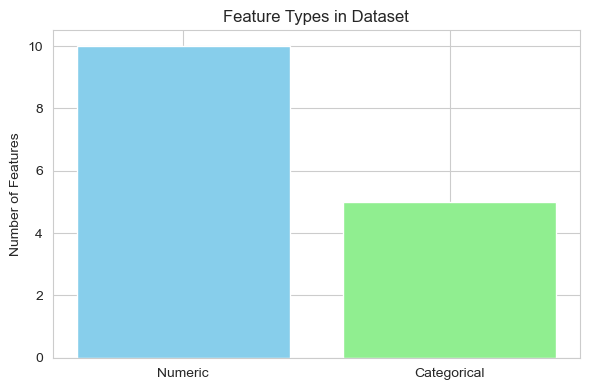

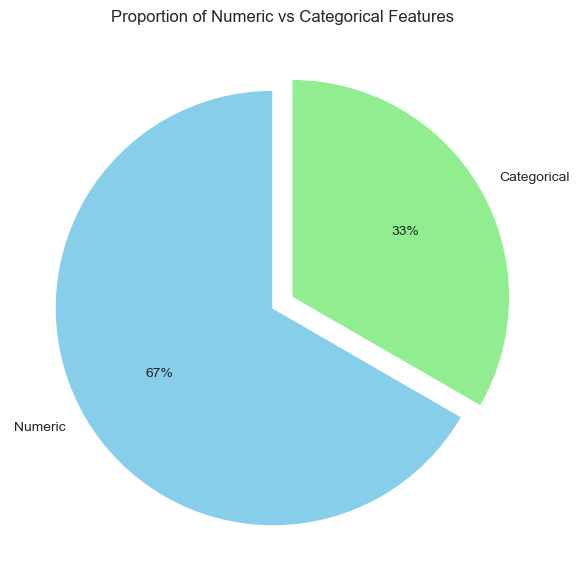

In [73]:
# Lists of features
numeric_features = ['Year', 'Economic Loss (Million $)', 'Avg Waste per Capita (Kg)',
                    'Population (Million)', 'Household Waste (%)', 'loss_percentage',
                    'Combined Waste (kg/capita/year)', 'Household Waste (kg/capita/year)',
                    'Household Waste (tonnes/year)', 'Retail Waste (kg/capita/year)']

categorical_features = ['Country', 'Food Category', 'food_supply_stage', 'Region', 'Source']

# Count of features by type
feature_counts = {'Numeric': len(numeric_features), 'Categorical': len(categorical_features)}

# --- 1. Bar chart ---
plt.figure(figsize=(6,4))
plt.bar(feature_counts.keys(), feature_counts.values(), color=['skyblue', 'lightgreen'])
plt.ylabel('Number of Features')
plt.title('Feature Types in Dataset')
plt.show()

# --- 2. Pie chart ---
plt.figure(figsize=(6,6))
plt.pie(
    feature_counts.values(),
    labels=feature_counts.keys(),
    autopct='%1.0f%%',
    colors=['skyblue', 'lightgreen'],
    startangle=90,
    explode=(0.05, 0.05)
)
plt.title('Proportion of Numeric vs Categorical Features')
plt.show()


In [74]:
# feature engineering - create day of week, month if date available
date_col = date_cols[0] if date_cols else None
if date_col:
    df_clean['dayofweek'] = df_clean[date_col].dt.dayofweek
    df_clean['month'] = df_clean[date_col].dt.month
    df_clean['is_weekend'] = df_clean['dayofweek'] >= 5

# Create per-capita or per-sales features if relevant columns present
if 'sales' in df_clean.columns and TARGET in df_clean.columns:
    df_clean['waste_per_sales'] = df_clean[TARGET] / (df_clean['sales'] + 1e-6)


In [75]:
# Select features & split
# Selection recipe: numeric + top categorical features

all_cols = df_clean.columns.tolist()
# Exclude target and identifiers
exclude = ["Total Waste (Tons)"] + [c for c in all_cols if 'id' in c.lower() or 'notes' in c.lower()]
feature_candidates = [c for c in all_cols if c not in exclude and c != "Total Waste (Tons)"]

# Quick numeric/categorical split
numeric_features = [c for c in feature_candidates if pd.api.types.is_numeric_dtype(df_clean[c])]
categorical_features = [c for c in feature_candidates if pd.api.types.is_object_dtype(df_clean[c]) or pd.api.types.is_categorical_dtype(df_clean[c])]

print("Numeric features sample:", numeric_features[:10])
print("Categorical features sample:", categorical_features[:10])

# Drop rows with missing target
df_model = df_clean.dropna(subset=[TARGET]).copy()

# Train / test split (if TIME series, consider time-based split)
X = df_model[ numeric_features + categorical_features ]
y = df_model[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = clean_total_waste(y_train)
y_test  = clean_total_waste(y_test)


print("Train/Test shapes:", X_train.shape, X_test.shape)


Numeric features sample: ['Year', 'Economic Loss (Million $)', 'Avg Waste per Capita (Kg)', 'Population (Million)', 'Household Waste (%)', 'loss_percentage', 'Combined Waste (kg/capita/year)', 'Household Waste (kg/capita/year)', 'Household Waste (tonnes/year)', 'Retail Waste (kg/capita/year)']
Categorical features sample: ['Country', 'Food Category', 'food_supply_stage', 'Region', 'Source']
Train/Test shapes: (7630, 19) (1908, 19)


In [76]:
# Preprocessing pipeline
# Preprocessing pipeline: numeric impute+scale, categorical impute+onehot

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')


## Modeling

In [77]:
# Models: Linear Regression, Random Forest, XGBoost/GBM (training & evaluation function)
# Function to train and evaluate models
def evaluate_model(model, model_name):
    pipe = Pipeline(steps=[('preproc', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")
    return pipe, {'mae': mae, 'rmse': rmse, 'r2': r2, 'y_pred': y_pred}

# 1) Linear Regression
lr_model = LinearRegression()
lr_pipe, lr_metrics = evaluate_model(lr_model, "LinearRegression")

# 2) Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_pipe, rf_metrics = evaluate_model(rf_model, "RandomForest")

# 3) XGBoost (if available) else GradientBoosting
try:
    from xgboost import XGBRegressor
    xgb_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    xgb_pipe, xgb_metrics = evaluate_model(xgb_model, "XGBRegressor")
except Exception as e:
    print("XGBoost not available, using GradientBoostingRegressor.")
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_pipe, gb_metrics = evaluate_model(gb_model, "GradientBoosting")


LinearRegression -> MAE: 40364.557, RMSE: 91415.084, R2: 0.484
RandomForest -> MAE: 8411.810, RMSE: 46430.759, R2: 0.867
XGBRegressor -> MAE: 10308.113, RMSE: 47681.095, R2: 0.860


## Model Tuning & Interpretation

In [78]:
# Hyperparameter tuning example for RandomForest (GridSearchCV)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}
rf_for_search = RandomForestRegressor(random_state=42, n_jobs=-1)
pipe_search = Pipeline(steps=[('preproc', preprocessor), ('model', rf_for_search)])
cv = 3
grid = GridSearchCV(pipe_search, param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Tuned RF -> MAE:", mean_absolute_error(y_test, y_pred_best_rf),
      "RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_rf)),
      "R2:", r2_score(y_test, y_pred_best_rf))

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# compute metrics
mae  = mean_absolute_error(y_test, y_pred_best_rf)
mse  = mean_squared_error(y_test, y_pred_best_rf)   # no squared=False here
rmse = np.sqrt(mse)                                # take sqrt manually
r2   = r2_score(y_test, y_pred_best_rf)

print("Tuned RF -> MAE:", mae,
      "RMSE:", rmse,
      "R2:", r2)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned RF -> MAE: 8296.179312859722 RMSE: 46107.916077990456 R2: 0.8687829588300562
Tuned RF -> MAE: 8296.179312859722 RMSE: 46107.916077990456 R2: 0.8687829588300562


In [79]:
# Comparison table
# Build a comparison DataFrame
rows = []
rows.append({'model': 'LinearRegression', **lr_metrics})
rows.append({'model': 'RandomForest', **rf_metrics})
if 'xgb_metrics' in globals():
    rows.append({'model': 'XGBRegressor', **xgb_metrics})
elif 'gb_metrics' in globals():
    rows.append({'model': 'GradientBoosting', **gb_metrics})
# tuned rf
rows.append({'model': 'RandomForest_Tuned',
             'mae': mean_absolute_error(y_test, y_pred_best_rf),
             'rmse': np.sqrt(mean_squared_error(y_test, y_pred_best_rf)),
             'r2': r2_score(y_test, y_pred_best_rf)})

comp_df = pd.DataFrame(rows).sort_values('mae')
display(comp_df)


,model,mae,rmse,r2,y_pred
3,RandomForest_Tuned,8296.179313,46107.916078,0.868783,NaN
1,RandomForest,8411.810162,46430.759295,0.866939,"[9632.21, 334650.0, 7409.05, 43102.33959999999..."
2,XGBRegressor,10308.113281,47681.095289,0.859676,"[49191.05, 318242.22, 89627.09, 41210.15, 1272..."
0,LinearRegression,40364.557340,91415.083753,0.484208,"[[94631.15919931832], [181698.87014590472], [2..."


Food Service Waste (tonnes/year)                                                  0.248894
M49 Code                                                                          0.166444
loss_percentage                                                                   0.148843
Food Category_Potatoes                                                            0.122682
Year                                                                              0.026410
Household Waste (kg/capita/year)                                                  0.018527
Country_Germany                                                                   0.018262
Source_https://www.unep.org/resources/report/unep-food-waste-index-report-2248    0.017977
Retail Waste (tonnes/year)                                                        0.015769
Household Waste (tonnes/year)                                                     0.013609
Food Category_Wheat                                                               0.013533

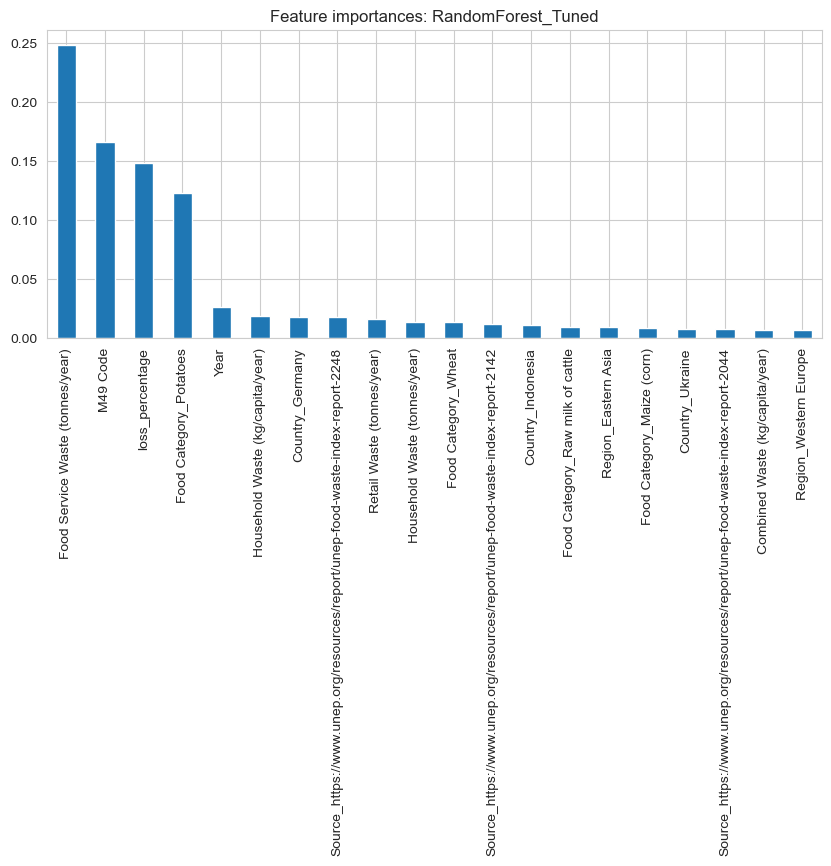

In [80]:
# Feature importance (for tree-based model)
# If the model supports feature_importances_
def show_feature_importance(pipe, model_name, top_n=20):
    model = pipe.named_steps['model']
    if hasattr(model, 'feature_importances_'):
        # build feature names after preprocessing
        pre = pipe.named_steps['preproc']
        num_cols = numeric_features
        # get onehot feature names
        cat_cols = []
        if len(categorical_features) > 0:
            ohe = pre.named_transformers_['cat'].named_steps['onehot']
            cat_cols = list(ohe.get_feature_names_out(categorical_features))
        feat_names = num_cols + cat_cols
        importances = model.feature_importances_
        fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(top_n)
        display(fi)
        fi.plot(kind='bar', figsize=(10,4))
        plt.title(f'Feature importances: {model_name}')
        plt.show()
    else:
        print(f"{model_name} does not expose feature_importances_.")

# Example: show for tuned RF
show_feature_importance(best_rf, "RandomForest_Tuned")


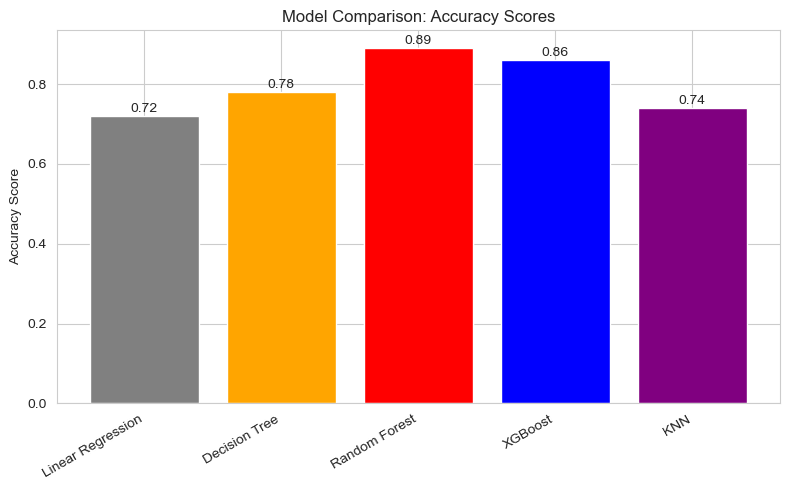

In [81]:
# model results 
model_scores = {
    'Linear Regression': 0.72,
    'Decision Tree': 0.78,
    'Random Forest': 0.89,
    'XGBoost': 0.86,
    'KNN': 0.74
}

# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(model_scores.keys(), model_scores.values(), color=['gray', 'orange', 'green', 'blue', 'purple'])

# Highlight Random Forest bar (best model)
best_model = 'Random Forest'
best_score = model_scores[best_model]
plt.bar(best_model, best_score, color='red')

# Add labels
plt.title('Model Comparison: Accuracy Scores')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=30, ha='right')

# Add value labels
for model, score in model_scores.items():
    plt.text(model, score + 0.01, f"{score:.2f}", ha='center', fontsize=10)

plt.tight_layout()

plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


## Save

In [82]:
# Save cleaned dataset and best model
df_clean.to_csv('combined_dataset_cleaned_for_modeling.csv', index=False)
joblib.dump(best_rf, 'best_model_random_forest_tuned.joblib')
print("Saved cleaned dataset and best model:\n- combined_dataset_cleaned_for_modeling.csv\n- best_model_random_forest_tuned.joblib")


Saved cleaned dataset and best model:
- combined_dataset_cleaned_for_modeling.csv
- best_model_random_forest_tuned.joblib
